# Téléchargement de bibliothèques

In [1]:
! pip install -q -U --upgrade scikit-learn==0.24 sklearn statsmodels hypertools pdpbox matplotlib==3.2.2 spacy==3.1.0 nltk==3.2.4 gensim scipy stopwordsiso pyspellchecker textblob_fr vaderSentiment-fr
! pip install -q -U git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
! pip install -q -U python-Levenshtein # Le module d'extension C contient des fonctions pour accélérer le calcul (word2vec, fasttext...)
! pip install -q -U gdown

     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 9.8 MB 52.7 MB/s 
     |████████████████████████████████| 59 kB 5.6 MB/s 
     |████████████████████████████████| 34.0 MB 93 kB/s 
     |████████████████████████████████| 6.4 MB 22.1 MB/s 
     |████████████████████████████████| 1.2 MB 51.4 MB/s 
     |████████████████████████████████| 24.1 MB 1.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 73 kB 1.5 MB/s 
     |████████████████████████████████| 2.7 MB 46.4 MB/s 
     |████████████████████████████████| 561 kB 48.9 MB/s 
     |████████████████████████████████| 187 kB 58.5 MB/s 
     |████████████████████████████████| 628 kB 59.5 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 10.1 MB 50.8 MB/s 
     |████████████████████████████████| 451 kB 60.2 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████

# Script de création de corpus
### https://colab.research.google.com/drive/18eT1u6dcCVYelNR9sbeXzeQNEHT02tGh

# Téléchargement de corpus (résultat du script)

In [ ]:
# ! gdown --id 1FrMd6HSVlLSk0Dj7fv-qJcZ0s9ZpNtVV

# Importation des bibliothèques

In [499]:
from multiprocessing import cpu_count
import os
from zipfile import ZipFile

import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from spellchecker import SpellChecker
from spacy.lang.fr import stop_words as fr_stop
import stopwordsiso

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

from sklearn.manifold import TSNE

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
from textblob.sentiments import NaiveBayesAnalyzer

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

# Extraction du corpus

In [500]:
with ZipFile('c_tweets.zip', 'r') as zf:
    zf.extractall('./')

# Telechargement des bibliothèque de NLTK

- punkt: NLTK tokenizer
- stopwords
- movie_reviews: dataset pour l'analyseur de sentiments naïf bayes
- vader_lexicon: outil d'analyse de sentiments basé sur des règles et un lexique

In [502]:
nltk.download(['punkt', 'stopwords', 'movie_reviews', 'vader_lexicon'], quiet = True)

True

# Création d'un répertoire pour l'exportation de données

In [503]:
export_dir = 'exports/'
if not os.path.isdir(export_dir):
   os.mkdir(export_dir)

# Importation et chargement du corpus

In [504]:
corpusdir = 'c_tweets/'
data = []

for filename in os.listdir(corpusdir):
  with open(corpusdir + filename, mode='r') as file:
    data.append(file.read())

tweets_df = pd.DataFrame(data, columns = ['tweet'])

In [505]:
print(f'{tweets_df.shape[0]} tweets')

4930 tweets


# Supprimer les tweets en double

In [506]:
print(f'{len(tweets_df.loc[tweets_df.duplicated()])} duplicated tweets')

15 duplicated tweets


In [507]:
tweets_df.drop_duplicates(inplace = True)

In [508]:
pd.set_option('display.max_colwidth', None)

tweets_df.sample(10)

,tweet
257,@mompontet Je m'isole en attendant le résultat du Test PCR. J'informe mes cas contacts d'aller se faire tester. Les tests d'hier soir indiquent peut-être la fin du covid19. Ne pas oublier que les autotests ne sont pas fiables à 100%. Je précise que cette réponse vient d'un médecin.
3030,"Depuis l’intervention indécente de #Macron, je suis encore plus fier d’être un pur sang ! Et vous ? \n#PasseVaccinalDeLaHonte #COVID19"
3500,"admettons que les Français soient vaccinés à 90% ... et de nouveau les vols commerciaux et touristiques reprendront ""Flight of #Covid19"" ... vu le faible pourcentage de vaccinés dans certains continents c'est peine perdue."
314,🇫🇷 FLASH - Pas de véritables mesures pour les collèges et les lycées aujourd'hui. #Fermezlesecoles #COVID19 \nhttps://t.co/QVxcywTS2a
1577,#COVID19 Un nouveau centre de vaccination ouvre à Mérignac \n➡️ https://t.co/EZLiWWOeAU https://t.co/NXJ4fhVtDC
3718,#Covid19 À #Rouen le centre Becquerel suspend les visites aux patients : « On déteste faire ça » https://t.co/6j97PfyBbY
805,"@ToyWax_35 @geniegn @Gblbvalot @Le___Doc Mais si ""associé au covid19"""
470,Les Réfugiés du Cameroun réclament #JUSTICE# pour détournement de fonds COVID19 de 2020 et trafic des enfants Réfugiés par un petit groupe du personnel HCR. Association pour la protection du Droit des Réfugiés au Cameroun.President DINAYE Laurent https://t.co/8RcKPlcfqv
1747,"On vous recommande chaudement cet ouvrage, carnet de bord de la première vague de #COVID19 aux Hôpitaux de @villecolmar \nDes témoignages qui éclairent sur la situation d'un hôpital, transposable ailleurs en France. #Edition \n⬇️⬇️❤️\nhttps://t.co/tEd5YQT8hN"
3632,#Vaccination 💉contre le #Covid19 : le point sur la dose de rappel et l’impact sur le passe sanitaire https://t.co/2YzqWCHK8D @cpam_01


In [509]:
tweets = tweets_df.copy()

# Traitement des émojis

## Décodage ses emojis et les traduire en français

## Demande de récuperation des émojis au site :
### https://emojiterra.com/fr/points-de-code

In [510]:
import urllib.request
from bs4 import BeautifulSoup

user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
url = "https://emojiterra.com/fr/points-de-code/"
headers = {'User-Agent': user_agent} 

request=urllib.request.Request(url, None, headers)
response = urllib.request.urlopen(request)
data = response.read()

## Récupération du tableau des émojis

In [511]:
soup = BeautifulSoup(data, 'html.parser')
table = soup.find('table')
emojis_df = pd.read_html(str(table))[0]

In [512]:
emojis_df.sample(10)

,#,Emoji + Unicode CLDR Short Name,Point(s) de code Unicode
1260,1261,🔨 Marteau,U+1F528
1181,1182,🔦 Torche,U+1F526
1094,1095,🩳 Short,U+1FA73
1953,1954,👐🏽 Mains Ouvertes : Peau Légèrement Mate,U+1F450 U+1F3FD
2534,2535,👨🏾‍🚒 Pompier Homme : Peau Mate,U+1F468 U+1F3FE U+200D U+1F692
2107,2108,👩🏼‍🦳 Femme : Peau Moyennement Claire Et Cheveux Blancs,U+1F469 U+1F3FC U+200D U+1F9B3
3447,3448,"👩🏼‍❤️‍👨🏼 Couple Avec Cœur : Femme, Homme Et Peau Moyennement Claire",U+1F469 U+1F3FC U+200D U+2764 U+FE0F U+200D U+1F468 U+1F3FC
2053,2054,🧔🏽‍♂️ Homme Barbu : Peau Légèrement Mate,U+1F9D4 U+1F3FD U+200D U+2642 U+FE0F
1449,1450,✔️ Coche,U+2714 U+FE0F
2034,2035,🧑🏾 Adulte : Peau Mate,U+1F9D1 U+1F3FE


## Séparation des emojis de leurs textes respectifs

In [513]:
emojis_table = emojis_df['Emoji + Unicode CLDR Short Name'].values.tolist()
emojis = {}
for line in emojis_table:
  emoji, text = line.split(' ', 1)
  emojis[emoji] = text

In [514]:
emojis.get('😇')

'Visage Souriant Avec Auréole'

## Définition d'une fonction qui convertit les emojis récupérés en texte

In [515]:
def demojize(text):
  global emojis
  words = text.split()
  for idx, word in enumerate(words):
    word_ = ''
    for char in word:
      if char in emojis.keys():
        char = " " + emojis[char] + " "
      word_ += char
    words[idx] = word_
  return " ".join(words)

In [516]:
demojize('😁vaccin 😁😁 Bon, 😉')

' Visage Souriant Aux Yeux Rieurs vaccin  Visage Souriant Aux Yeux Rieurs  Visage Souriant Aux Yeux Rieurs  Bon,  Visage Faisant Un Clin D’œil '

## Conversion des emojis en texte pour l'analyse des sentiments

In [517]:
tweets['tweet_emojis'] = tweets['tweet'].apply(lambda tweet: demojize(tweet))

# Test de subjectivité

## *Simple french analyzer*

### *Blobber* documentation :
#### https://textblob.readthedocs.io/en/dev/advanced_usage.html, https://stackoverflow.com/questions/33241842/textblob-naivebayesanalyzer-extremely-slow-compared-to-pattern

In [518]:
tb_fr = Blobber(pos_tagger = PatternTagger(), analyzer = PatternAnalyzer())
tweets['subjectivité'] = tweets['tweet_emojis'].apply(lambda tweet: tb_fr(tweet).sentiment[0])

In [519]:
tweets.sample(10)

,tweet,tweet_emojis,subjectivité
172,#CAN2021 | Au moins 4️⃣ joueurs du #BurkinaFaso et le coach positifs au #COVID19 . Le staff burkinabè conteste la fiabilité des tests effectués et l’indépendance des préleveurs. Il parle de manipulation. \n#TotalEnergiesAFCON2021 https://t.co/eybhBk3G4W,#CAN2021 | Au moins 4️⃣ joueurs du #BurkinaFaso et le coach positifs au #COVID19 . Le staff burkinabè conteste la fiabilité des tests effectués et l’indépendance des préleveurs. Il parle de manipulation. #TotalEnergiesAFCON2021 https://t.co/eybhBk3G4W,0.000000
4801,@Mediavenir 🇫🇷 FLASH - Les #Vaccinés représentaient 58% des décès et 44% des entrées à l'hôpital en soins critiques en décembre. (BFMTV) #COVID19France #COVID19,@Mediavenir 🇫🇷 FLASH - Les #Vaccinés représentaient 58% des décès et 44% des entrées à l'hôpital en soins critiques en décembre. (BFMTV) #COVID19France #COVID19,0.000000
1040,"URGENT - Jean Castex : ""La vaccination de tous les enfants, sous réserve des avis médicaux, sera ouverte d'ici la fin de l'année"" #Coronavirus #covid19 #école #vacances https://t.co/xI0CcdXaoW","URGENT - Jean Castex : ""La vaccination de tous les enfants, sous réserve des avis médicaux, sera ouverte d'ici la fin de l'année"" #Coronavirus #covid19 #école #vacances https://t.co/xI0CcdXaoW",0.066000
1004,"Importante réflexion sur la crise de l'hôpital : rigide par nature, l'🏥 ne peut pas seul faire face à des tensions ↗️ liées au vieillissement davantage qu'au #COVID19\n\n➡️Réinstaurer la permanence des soins ambulatoires de médecine de ville\n\n#JPNordmann\n\nhttps://t.co/SkSubDnaxB","Importante réflexion sur la crise de l'hôpital : rigide par nature, l' Hôpital ne peut pas seul faire face à des tensions ↗️ liées au vieillissement davantage qu'au #COVID19 ➡️Réinstaurer la permanence des soins ambulatoires de médecine de ville #JPNordmann https://t.co/SkSubDnaxB",0.150000
4731,Bonjour @cnb @Avocats_Paris @CPAM_75 @syndicatavocats @UJAdeParis \n \nArrêt de travail #COVID19 indemnisé pour tous les travailleurs indépendants et professions libérales…sauf pour les avocats ?\n\nC’est une erreur ou il y a une explication logique qui m’échappe ? https://t.co/mWIg4E85Ua,Bonjour @cnb @Avocats_Paris @CPAM_75 @syndicatavocats @UJAdeParis Arrêt de travail #COVID19 indemnisé pour tous les travailleurs indépendants et professions libérales…sauf pour les avocats ? C’est une erreur ou il y a une explication logique qui m’échappe ? https://t.co/mWIg4E85Ua,0.140000
2299,"@Elishev18121042 @Seempleetoo @sciensano Comme par hazard , il faut retirer se qui fait paniquer ....la verite","@Elishev18121042 @Seempleetoo @sciensano Comme par hazard , il faut retirer se qui fait paniquer ....la verite",0.000000
3078,"@Actu17 Au lieu de se focaliser sur le covid19, ils se secouent ou cela va continuer ?","@Actu17 Au lieu de se focaliser sur le covid19, ils se secouent ou cela va continuer ?",0.000000
1607,#COVID19 est-ce que nos gouvernants ont carrément lâché l'affaire ??\n#208k #coronavirus #France #Pandemie,#COVID19 est-ce que nos gouvernants ont carrément lâché l'affaire ?? #208k #coronavirus #France #Pandemie,0.000000
555,Ligue 1 : Vers une jauge proportionnelle à la taille du stade ? https://t.co/QCO4o0USjL #Foot #COVID19 #Ligue1,Ligue 1 : Vers une jauge proportionnelle à la taille du stade ? https://t.co/QCO4o0USjL #Foot #COVID19 #Ligue1,0.000000
3996,@LeHuffPost Je vais faire 38kms pour faire ma 3ème dose!😤 Parce que le vaccinodrome qui était plus près de chez moi a fermé en octobre et ne rouvrira pas! 😡 #gouvernement @olivierveran #COVID19,@LeHuffPost Je vais faire 38kms pour faire ma 3ème dose! Visage Avec Fumée Sortant Des Narines Parce que le vaccinodrome qui était plus près de chez moi a fermé en octobre et ne rouvrira pas! Visage Boudeur #gouvernement @olivierveran #COVID19,-0.066667


> Un score élevé de *subjectivité* indique qu'il s'agit principalement d'une opinion publique et non d'une information factuelle

## Filtrer les tweets subjectifs
- Seuil (*Threshold*) : 35%

In [520]:
tweets = tweets[tweets['subjectivité'] >= 0.35]

In [521]:
print(f'{tweets.shape[0]} subjective tweets')

286 subjective tweets


In [522]:
tweets.drop('subjectivité', axis = 1, inplace = True)
tweets.reset_index(inplace = True, drop = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Analyse des sentiments

## *Simple analyzer*

In [523]:
tweets['polarité_simple'] = tweets['tweet_emojis'].apply(lambda text: tb_fr(text).sentiment[1])

In [524]:
tweets['sentiment_simple'] = tweets['polarité_simple'].apply(lambda x: 'Negative' if x < 0 else ('Neutre' if x == 0 else 'Positive'))

In [525]:
tweets[['tweet', 'sentiment_simple']].sample(10)

,tweet,sentiment_simple
30,"@SanteBelgique #BeGov à quand la 4e dose de ""vaccin"" #COVID19 ?\n\nFaisons preuve d’anticipation pour une fois ! 😅😂 https://t.co/MAXoYCBAL1",Positive
235,T’es un ancien si t’as connu ça.\n#castex #COVID19 #touchezpasauxenfants #conseildedefense https://t.co/GKKY7pyg3p,Positive
97,Nous sommes devenus ce jour en @Mairie10Paris avec 17 blocs de vaccination un des plus + gros centre de #paris qui accueille 1.700 pers./jour soit 12.000 parisien.nes/sem. 7/7j\nUn immense 🙏 aux volontaires pour cette superbe organisation \n#COVID19 #VaccinezVous #COVID19France https://t.co/neUERL50xZ,Positive
129,"[Presse] Après avoir réactivé sa cellule de crise le 25/11, l’@HNordOuest, le CH de Belleville et l’hôpital de Beaujeu, déclenchent aujourd’hui le niveau 2 du #PlanBlanc pour faire face à une situation de forte tension ➡️ https://t.co/D0hQ8kflzm\n#COVID19",Positive
12,Ah nostalgie quand tu nous tiens 🤣 #COVID19 https://t.co/9eZzezI6fV,Neutre
255,"#PAYSBAS 🇳🇱 \n\nVous dites, efficacité du vaccin? #Veran #Castex #Conseildedefense😅\nNEXT!\n\n➡️ L'ex-reine Beatrix des #PaysBas est positive au #COVID19. \nElle a déclaré avoir été vaccinée à deux reprises et avoir déjà reçu une dose de rappel. #3emeDose #RT\n\nhttps://t.co/6gSYwV6HnQ https://t.co/v6M0SzEohh",Positive
31,"Les intoxicateurs sur le podium : #FranceSoir, Sputnik, RT France... Meilleurs alliés du #COVID19 et de l'extrême-droite 😬 https://t.co/h4uWPoBQH7",Positive
238,"➡#Covid19 : de nouveaux efforts pour sauver #Noel ?\n\n🗣️@dupontaignan : ""Il faut plutôt du bon sens, par ex, la gratuité des tests (...) En plein rebond épidémique, laisser des tests payants est une aberration""\n\n📺 #LesMatinsLCI | @EliMartichoux https://t.co/xwdkRaiVWV",Positive
201,(1/2) Vous pouvez aider vos enfants à avoir une bonne expérience de vaccination contre la #Covid19. Voici des conseils pour apaiser leurs inquiétudes et les vôtres lors du rendez-vous de vaccination : https://t.co/8VJQh2NqNw,Positive
265,"La pandémie n'existe pas, elle a été organisée artificiellement. https://t.co/egX0dIBAAC #pandémie #COVID19 #PaulCraigRoberts",Positive


> *Simple Sentiment Analyzer* ne donne pas de résultats exacts, et ne fait pas la distinction entre les opinions et les informations factuelles

> Nous utiliserons l'analyseur de sentiments *Vader* (Valence Aware Dictionary et sEntiment Reasoner)

## *VADER*

#### Le *compound score* est la somme des scores positifs, négatifs et neutres, le score est ensuite normalisé entre -1 (négatif le plus extrême) et +1 (positif le plus extrême)

In [526]:
SIA = SentimentIntensityAnalyzer()
tweets['polarité_vader'] = tweets['tweet_emojis'].apply(lambda text: SIA.polarity_scores(text)['compound']) # compound = agrégé

In [527]:
tweets['sentiment_vader'] = tweets['polarité_vader'].apply(lambda x: 'Negative' if x < 0 else ('Neutre' if x == 0 else 'Positive'))

> Plus le *compound score* est proche de +1, plus la positivité du texte est élevée

In [528]:
tweets[['tweet', 'sentiment_simple', 'sentiment_vader']].sample(10)

,tweet,sentiment_simple,sentiment_vader
285,"@lionnelluca06 NORMAL, DANS LE VACCIN CONTRE LA COVID19 IL Y A DES EMBRYONS DE CHIMPANZÉS ET DES OGM GÉNÉTIQUEMENT MODIFIÉS, ET JE VOUS PARLE PAS DU RESTE 😁😁",Positive,Positive
41,Un bon et joyeux Noël🎄 aux petits Français de 5 à 11 ans qui auront comme cadeau par l’état Français une dose Pfizer !! #PassDeLaHonte #COVID19 #VeranDemission,Positive,Positive
166,La France... \nCe pays qui n'a pas de vaccin #COVID19\nMais qui fait presque 40 #conseildedefense !!\nC'est beau la Macronie.\nC'est beau... https://t.co/bpCfLQLxon,Positive,Positive
155,Fermeture des #discothèques !! Merci monsieur #Castex on va pas m’obliger à aller « en boîte » le soir du 31 !!! 👏👏👏😂😂😂 #COVID19,Positive,Negative
282,"Donc le gouvernement ferme les discothèques mais aucun pass sanitaire, ni rien pour les meetings qui rassemble plusieurs milliers de personnes... bon ok... on va s'en sortir un jour ? #COVID19 #PasseSanitaire",Positive,Positive
189,"""Il faut sauver Noël, l'été, l'Horeca... mais on oublie le plus important"" \n@lalibrebe #COVID19\nhttps://t.co/GjcvDra7k6",Positive,Positive
227,"Il y a 2 semaines, on était plus forts que soit disant l’Allemagne et les pays d’Europe de l’Est, aujourd’hui on a droit aux discours alarmistes ??!!!??? 😳😬#COVID19 https://t.co/73n5lEwxDY",Positive,Negative
90,[A défaut de #prime] Quelques douceurs pour toute l’équipe médico-soignante… 🍫🍬\n🗓Calendrier de l’avent créé par une #AideSoignante 😍 @CHUBordeaux \n\n#médecine #COVID19 #DIY \n🔛Join us ==&gt;\nbienvenueauxsoignants@chu-bordeaux.fr \n\n👋🏻 #hôpital #infirmière #VaccinezVous https://t.co/tp6WbCJsLd,Positive,Positive
164,"2/2 - après avoir longuement réfléchi sur les risques d'attraper le Covid19 où accepter la vaccination, mais pour l'emmerder LUI, cet élu de Dieu (et non du peuple). LUI, celui qui SAIT ce qui est bon pour nous. Lui, le protecteur suprême de l'Europe !",Positive,Positive
43,"@+ Les #Twittos et Bon #8janvier2022 - #8janviertousdanslarue = C'est une boucle temporelle, la boucle sera donc bouclée. 😎🙃Un-Forme-A-Sion (Lumière) #Liberté #Covid19 #Vaccin #PassVaccinal de la honte. #Doctor - #Docteur à la bonne heure. \nhttps://t.co/UbnqXJPVxQ",Positive,Positive


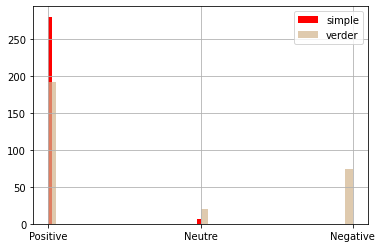

In [529]:
tweets['sentiment_simple'].hist( bins = 40, color = 'red', alpha = 1)
tweets['sentiment_vader'].hist( bins = 40, color = 'tan',  alpha = 0.7)
plt.legend(["Simple analyzer","veder"])

> *Vader* donne des résultats plus précis

In [530]:
tweets.drop(['tweet_emojis', 'polarité_simple', 'sentiment_simple', 'polarité_vader'], axis = 1, inplace = True)
tweets.rename(columns = {'sentiment_vader': 'sentiment'}, inplace = True)

In [531]:
tweets.sample(10)

,tweet,sentiment
58,"Monde humaine!!!\nCe monde ne passera pas !!!\nA choisir le diable n'a rien à perdre sur un déluge planétaire.\nVus CoviD19,etc. https://t.co/cINvmboVS9",Negative
113,"Evolution du nb d'hospitalisations #COVID19 le 6 dec par dept.\n6789 hospi en 7 J +42 %\n1041 réa en 7J +39%\n457 décès en 7J +51%\nEncore une très forte hausse des hospitalisations, réa décès en 1 semaine plutôt dans le sud-est.\nhttps://t.co/Fg5kFh4F0Y https://t.co/G63fkrvmjw",Positive
171,"C’est pas le 1er, à votre avis pk le gvt est si gentils avec les #RS Le blocage de #Booba montre que dire la vérité est un motif de censure maintenant.#booba #PasseVaccinalDeLaHonte #COVID19 https://t.co/lfppcfibUd https://t.co/P80PeewN1A",Positive
182,@kmatreyek Quand allez-vous arrêter de collecter des échantillons de virus capables de déclencher une #Pandemie ?\n\n#COVID19 #SARS_CoV_2 #SARS_CoV,Negative
31,"Les intoxicateurs sur le podium : #FranceSoir, Sputnik, RT France... Meilleurs alliés du #COVID19 et de l'extrême-droite 😬 https://t.co/h4uWPoBQH7",Positive
46,"Le Gouvernement Macron, en association avec l’équipe du Savant de Marseille, vient d’inventer une solution miracle pour éviter de se contaminer contre le Covid19: « la Bulle sanitaire ».\n\nAmi.e.s https://t.co/59XO279bA9 n’hésitez pas à en commander sur « https://t.co/BZudpbaQdw »",Positive
32,La récompense de cette 3ème dose : l'impression du nouveau pass sanitaire ! 🎉\n\n#Vaccin #Vacciné #vaccination #COVID19 #Covid,Positive
25,Si la rentrée n’est pas repoussée je ss obligé de me rendre au lycée et donner cours à mes élèves en étant cas contact car en tant que contractuel je dois faire bonne figure auprès de ma hiérarchie et ne ps m’absenter pr pouvoir retrouver ce poste et ce lycée l’année pro #COVID19,Positive
279,Bon ben rien pour les vacances des primaires et les lycéens.... #COVID19 #conseildedefense #Vacances,Positive
247,"Rappel amical, notre foire aux questions #COVID19 pour nos compatriotes au Canada est régulièrement mise à jour.\nConsultez-la. \nhttps://t.co/PEh4a1ymkZ\nSuivez également @FR_Consulaire et @ConseilsVoyages. https://t.co/DOaxlvM8Y8",Neutre


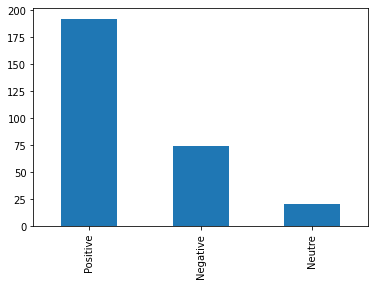

In [532]:
tweets['sentiment'].value_counts().plot.bar()

> En moyenne, l'opinion des francophones sur la situation covid est positive

## Exportation des tweets avec les sentiments que nous avons obtenus

In [533]:
! pip install -q -U openpyxl
tweets.to_excel(export_dir + 'tweets_sentiment_data.xlsx', index = False)

# Prétraitement

## Chargement des *Stop-words*

#### Chargement des *Stop-words* français

In [534]:
stopwords = nltk.corpus.stopwords.words('french')
len(stopwords)

157

In [535]:
stopwords = fr_stop.STOP_WORDS
len(stopwords)

507

#### Étant donné que les *Stop-words* de NLTK ne sont pas nombreux, nous allons les importer d'une source différente

In [536]:
stopwords = stopwordsiso.stopwords("fr")
len(stopwords)

691

#### Nous pouvons ajouter d'autres *Stop-words*

In [537]:
stopwords.update({'janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre'})
stopwords.update({'lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche'})
stopwords.update({'aaaaah', 'aaaah'})

## Suppression des noms personnels

In [538]:
names = []
table = pd.read_table('https://www.usna.edu/Users/cs/roche/courses/s15si335/proj1/files.php%3Ff=names.txt&downloadcode=yes', header = None)
names.extend([name.lower() for _ in table.values.tolist() for name in _])
names = set(names)

## Correcteur d'orthographe

In [539]:
spell = SpellChecker(language = 'fr')
spell.word_frequency.load_words(['covid']) # autoriser d'autres mots non français

## French Lemmatizer

In [540]:
lemmatizer = FrenchLefffLemmatizer()

## French Stemmer

In [541]:
stemmer = SnowballStemmer('french')

## Nettoyage

- Suppression des identifiants Twitter (@user)
- Suppression des URLs du texte
- Suppression des hashtags
- Suppression des ponctuations, des chiffres et des caractères spéciaux
- Suppression des émojis
- Suppression des mots de longueur <= 3
- Suppression des *Stop-words*
- Supprimer des noms de personnels
- Filtrer les mots français
- Correction d'orthographe
- Lemmatisation
- Stemming

In [542]:
def nettoyage(text):
  global stopwords
  global names
  global spell
  global lemmatizer
  global stemmer

  text = re.sub(r'@[\w]*', '', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'#[\w]*', '', text)
  text = re.sub(r'[^A-Za-z#çéâêîôûàèìòùëïü\-]', ' ', text)
  text = [word for word in word_tokenize(text.lower()) if word not in stopwords and len(word) > 3]
  text = [word for word in text if word not in names]
  text = [word for word in text if word not in spell.unknown(text)]
  text = [spell.correction(word) for word in text]
  text = [lemmatizer.lemmatize(word, 'n') for word in text]
  text = [stemmer.stem(word) for word in text]

  return " ".join(text)

In [543]:
tweets['processed_tweet'] = tweets['tweet'].apply(lambda tweet: nettoyage(tweet))

In [544]:
tweets.sample(10)

,tweet,sentiment,processed_tweet
84,"#COVID19 ""Un nouveau traitement est sur le point d'arriver. Il est commercialisé par le laboratoire Pfizer et sera destiné uniquement aux personnes à forts risques"" @olivierveran #PasseVaccinal #Vaccin https://t.co/bdb2BCdTJx",Negative,trait point arriv commercialis laboratoir destin uniqu fort risqu
129,"[Presse] Après avoir réactivé sa cellule de crise le 25/11, l’@HNordOuest, le CH de Belleville et l’hôpital de Beaujeu, déclenchent aujourd’hui le niveau 2 du #PlanBlanc pour faire face à une situation de forte tension ➡️ https://t.co/D0hQ8kflzm\n#COVID19",Negative,press réactiv cellul cris hôpital déclenchent niveau fair fac situat fort tension
154,Magnifique documentaire pour comprendre l’escroquerie du #COVID19 #8janviertousdanslarue \n#passvaccinnal https://t.co/fGpgL8t9RF,Positive,magnif documentair comprendr escroquer
215,"Clair, intelligent, précis bravo Mme 👌👏 #passvaccinal #COVID19 https://t.co/AWwaYEfmuS",Positive,intelligent prec
136,@gkierzek Excellent... c'est dire l'ampleur de ka confusion populaire face au défilé des spécialistes du covid19.,Positive,excellent ampleur confus populair fac défil spécial covid
159,"Posez vous les bonnes questions, il en va de votre avenir ! #COVID19 https://t.co/y2kiGAbi4L",Positive,pos bon question aven
87,"#COVID19 bon; regarder Castex (après avoir mis sont chir dans poche et faire des grimaces) expliquer ""gnagn nous on confine pas comme les pays, gnagn les vax!, ce qui compte c'est les capacité hospit...tout est mild!""; c'est comme regarder un clown faire de la physique quantique",Positive,regard chir poch fair grimac expliqu confin pay compt capac regard clown fair physiqu quantiqu
134,Une bonne façon de faire le ménage sans payer !!! #covid19 #VaccinationObligatoire\nÇa va devenir la nouvelle méthode de licenciement pour 2022 !!! https://t.co/q1Jud2XYuI,Positive,bon fair ménag pai deven nouvel méthod licenci
239,Est-ce que des medias vont parler de la hausse des hospitalisations #COVID19 des enfants ?!\n\nOu doit-on se résoudre à laisser nos enfants au bon vouloir du #ProtocoleTousInfectes ?!\n\n@AnneLeGall_ @FrancoisBeguin @AnissaBmd @boylandry @sandrine_cabut @EmmanuelleLuca1 @MarcGozlan @ https://t.co/3RI0JxuPfn,Positive,medi hauss hospitalis enfant résoudr enfant vouloir
243,#COVID19 : le #masque #FFP2 plus efficace que le masque chirurgical ?\nVia @LePoint https://t.co/bIk9TUby2N,Negative,efficac masqu chirurgical


# Modèles de représentation

## Diviser les données

In [545]:
X = tweets['processed_tweet']
y = tweets['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Tokénisation

In [546]:
word_tokens = X.apply(lambda tweet: word_tokenize(tweet))
train_tokens = X_train.apply(lambda tweet: word_tokenize(tweet))
test_tokens = X_test.apply(lambda tweet: word_tokenize(tweet))

## Modèles de représentation

### BoW - *Bag-of-Words*

In [547]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

### Word2Vec

In [548]:
w2vec_model = Word2Vec(vector_size = 300, window = 20, workers = cpu_count())
w2vec_model.build_vocab(word_tokens)
w2vec_model.train(word_tokens, total_examples = len(word_tokens), epochs = 15)

(2888, 30645)

### Fast Text

In [549]:
fastText_model = FastText(vector_size = 300, window = 20, workers = cpu_count())
fastText_model.build_vocab(word_tokens)
fastText_model.train(word_tokens, total_examples = len(word_tokens), epochs=15)

(2888, 30645)

In [550]:
def get_embedding(model, words):
  valid_words = [word for word in words if word in model.wv.index_to_key]
  if valid_words:
      embedding = np.zeros((len(valid_words), 300), dtype=np.float32)
      for idx, word in enumerate(valid_words):
          embedding[idx] = model.wv[word]

      return np.mean(embedding, axis=0)
  else:
      return np.zeros(300)

def vectoriser_avg(model, X):
  X_embeddings = np.array([get_embedding(model, words) for words in X])
  return X_embeddings


> Pour chaque document (tweet), on calcule la somme des vecteurs associés aux mots qui le composent, on met des zéros si le mot n'est pas dans le vocabulaire

## Vectorisation des données d'entrainement et du test

In [551]:
X_train_w2v = vectoriser_avg(w2vec_model, train_tokens)
X_test_w2v = vectoriser_avg(w2vec_model, test_tokens)

In [552]:
X_train_ftxt = vectoriser_avg(fastText_model, train_tokens)
X_test_ftxt = vectoriser_avg(fastText_model, test_tokens)

### Visualisation

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

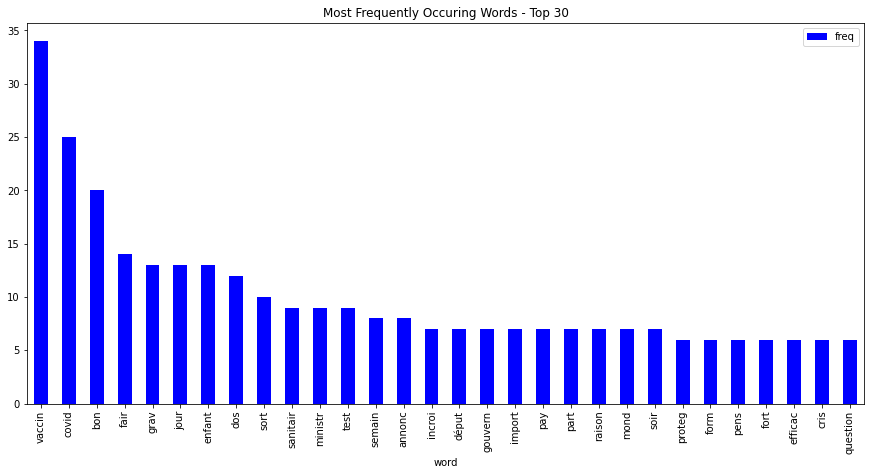

In [553]:
sum_words = X_train_bow.sum(axis=0).tolist()
sum_words.extend(X_test_bow.sum(axis=0).tolist())
sum_words = np.array(sum_words)

words_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

#### *Bag-of-Words*

In [554]:
pd1 = pd.DataFrame(X_train_bow.toarray())
pd2 = pd.DataFrame(X_test_bow.toarray())
bow_df = pd.concat([pd1, pd2])
bow_df.columns = vectorizer.get_feature_names()

#### Exportation (*Bag-of-Words*)

In [555]:
bow_df.to_csv(export_dir + 'bow.csv', index = False)

In [556]:
bow_df.sample(10)

,abeil,aberr,accord,accueil,achat,achet,activ,admettr,adopt,ador,affirm,afflig,affluenc,agré,aid,aigr,aillent,alib,aller,allez,alli,allumag,alpag,ami,amical,among,amour,ampleur,analys,ancien,angin,animal,anniversair,annonc,annul,anné,antiviral,apais,apparaissent,apprendr,...,vient,vieux,vill,virus,vit,viv,vivon,vivr,volontair,vouloir,vrai,vérif,vérit,week,yolo,zizan,âgé,écart,échantillon,échec,échel,écol,écout,égal,élev,élit,émiss,émot,épidem,épidémiolog,épisod,époqu,épuis,établ,étap,éven,évit,évitent,évolu,évoquent
8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Déclaration des fonctions de visualisation pour les vecteurs de mots

In [557]:
def TSNE_plot_vocab(model):
  labels = []
  tokens = []

  for word in model.wv.index_to_key:
      tokens.append(model.wv[word])
      labels.append(word)
  
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23, n_jobs = cpu_count())
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])
      
  plt.figure(figsize=(16, 16)) 
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
  plt.show()

def TSNE_mots_similaires(model, word):
  arr = np.empty((0,300), dtype='f')
  word_labels = [word]
  nb_sim_words = 10
  close_words = model.wv.similar_by_word(word)[:nb_sim_words]

  arr = np.append(arr, np.array([model.wv[word]]), axis=0)
  for wrd_score in close_words:
    wrd_vector = model.wv[wrd_score[0]]
    word_labels.append(wrd_score[0])
    arr = np.append(arr, np.array([wrd_vector]), axis=0)

  tsne = TSNE(n_components=2, random_state=0)
  np.set_printoptions(suppress=True)
  Y = tsne.fit_transform(arr)

  x_coords = Y[:, 0]
  y_coords = Y[:, 1]

  color = ['red']
  for i in range(nb_sim_words):
    color.append('blue')

  plt.scatter(x_coords, y_coords, c = color)

  for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(1, 5), textcoords='offset points')
  plt.xlim(min(x_coords)-100, max(x_coords)+100)
  plt.ylim(min(y_coords)-100, max(y_coords)+100)
  plt.show()

#### *Word2vec*

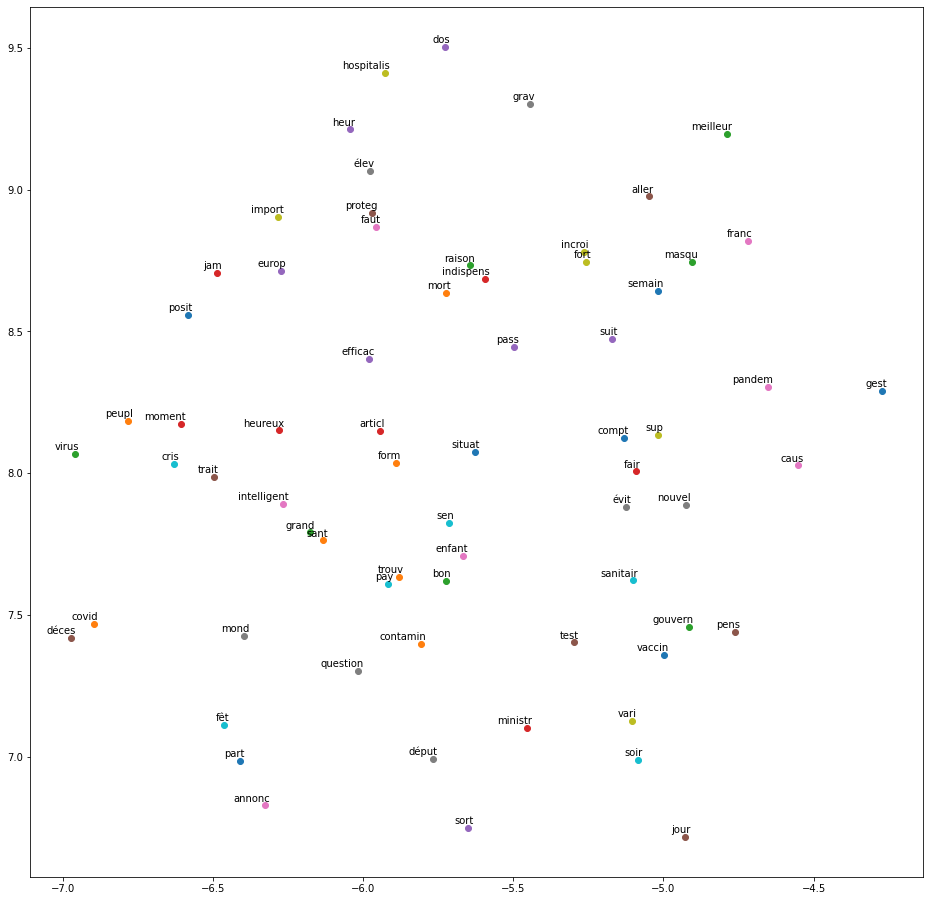

In [558]:
TSNE_plot_vocab(w2vec_model)

In [559]:
w2vec_model.wv.most_similar('vaccin')

[('gouvern', 0.2257436364889145),
 ('vari', 0.20270119607448578),
 ('form', 0.13613738119602203),
 ('pens', 0.1312275528907776),
 ('fair', 0.11890861392021179),
 ('virus', 0.11326742172241211),
 ('semain', 0.10458063334226608),
 ('soir', 0.09786596894264221),
 ('ministr', 0.0974099189043045),
 ('franc', 0.08470477908849716)]

> Les mots les plus corrélés avec *vaccin* et leurs seuils de corrélation

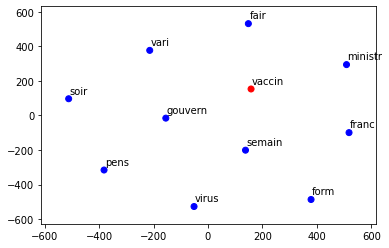

In [560]:
TSNE_mots_similaires(w2vec_model, "vaccin")

#### *Fast Text*

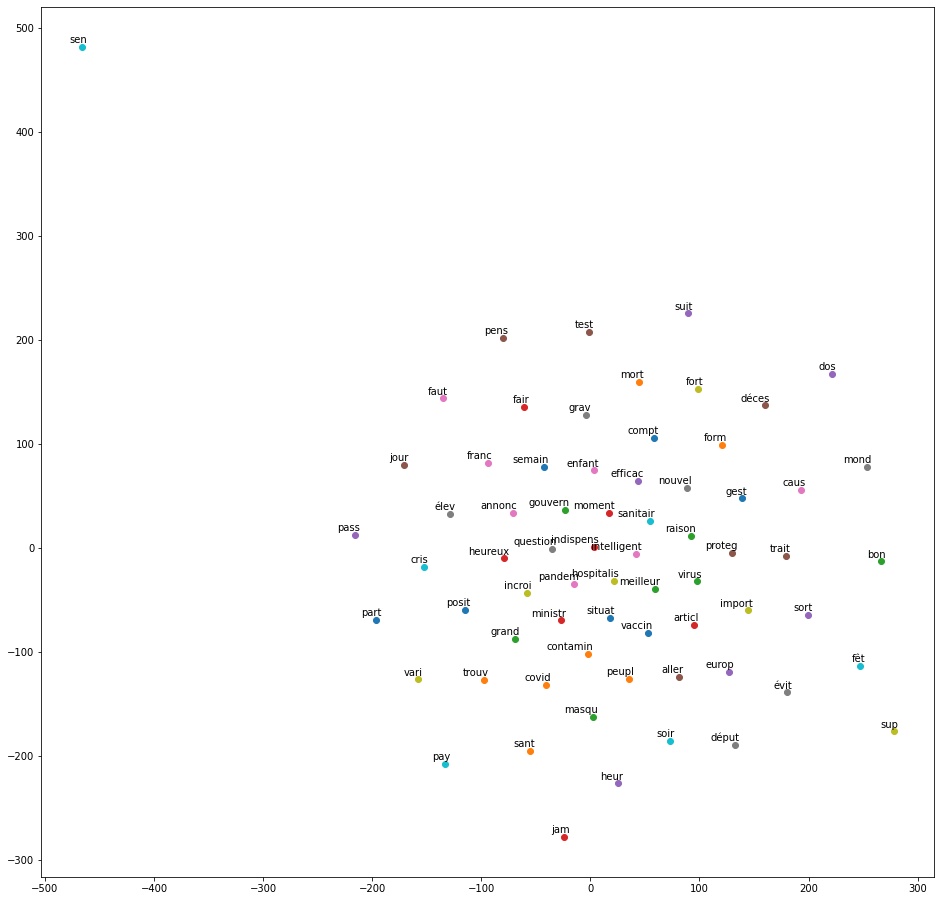

In [561]:
TSNE_plot_vocab(fastText_model)

In [562]:
fastText_model.wv.most_similar('vaccin')

[('dos', 0.13282303512096405),
 ('pens', 0.13034150004386902),
 ('heureux', 0.1269383728504181),
 ('indispens', 0.11780335009098053),
 ('aller', 0.11453504860401154),
 ('moment', 0.11200413852930069),
 ('évit', 0.11035245656967163),
 ('faut', 0.11003785580396652),
 ('mort', 0.10440515726804733),
 ('grav', 0.09844818711280823)]

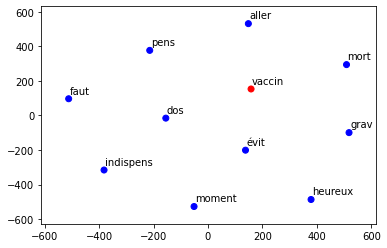

In [563]:
TSNE_mots_similaires(fastText_model, "vaccin")

# Réduction de la dimensionnalité

## *Latent Semantic Analysis/Index*

> Nous utiliserons LSA pour réduire la dimensionnalité des données avant de les intégrer dans un modèle

### *Bag of words*

In [564]:
print(f'dimension initiale {X_train_bow.shape[1]}')

dimension initiale 828


#### Nous appliquons *LSA*

In [565]:
lsa_obj = TruncatedSVD(n_components=300, n_iter=100, random_state=42)
lsa_obj.fit(X_train_bow)

TruncatedSVD(n_components=300, n_iter=100, random_state=42)

#### Informations

In [566]:
lsa_obj.explained_variance_ratio_.sum()

1.0

> 87% de l'inertie est conservée après la réduction

#### Transformation

In [567]:
X_train_bow_lsa = lsa_obj.transform(X_train_bow)
X_test_bow_lsa = lsa_obj.transform(X_test_bow)

### *Word2vec*

In [568]:
print(f'dimension initiale {X_train_w2v.shape[1]}')

dimension initiale 300


In [569]:
lsa_obj = TruncatedSVD(n_components=50, n_iter=100, random_state=42)
lsa_obj.fit(X_train_w2v)

TruncatedSVD(n_components=50, n_iter=100, random_state=42)

In [570]:
lsa_obj.explained_variance_ratio_.sum()

0.963384629118383

> 99% de l'inertie est conservée après la réduction

In [571]:
X_train_w2v_lsa = lsa_obj.transform(X_train_w2v)
X_test_w2v_lsa = lsa_obj.transform(X_test_w2v)

### *Fast Text*

In [572]:
print(f'dimension initiale {X_train_ftxt.shape[1]}')

dimension initiale 300


In [573]:
lsa_obj = TruncatedSVD(n_components=50, n_iter=100, random_state=42)
lsa_obj.fit(X_train_ftxt)

TruncatedSVD(n_components=50, n_iter=100, random_state=42)

In [574]:
lsa_obj.explained_variance_ratio_.sum()

0.9714836409298114

> 87% de l'inertie est conservée après la réduction

In [575]:
X_train_ftxt_lsa = lsa_obj.transform(X_train_ftxt)
X_test_ftxt_lsa = lsa_obj.transform(X_test_ftxt)

# Entrainement du modèle

## Métriques

In [576]:
metrics_bow = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

metrics_w2v = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

metrics_ftxt = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

## *Linear Support Vector Machine*
> *Linear SVM* est plus compatible avec les données textuelles


#### Paramètres

In [577]:
param_svm = {
  "loss" : ["hinge", "log"], # La fonction de perte à utiliser. La valeur par défaut est "hinge", ce qui donne un SVM linéaire, la perte « log » donne une régression logistique, un classificateur probabiliste.
  "alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], # Constante qui multiplie le terme de régularisation. Plus la valeur est élevée, plus la régularisation est forte.
  "penalty" : ["l1", "l2"] # Spécifie la norme utilisée dans la pénalisation.
}

### *Bag-of-Words*

In [578]:
svm_grid_bow = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [579]:
model_svm_bow = svm_grid_bow.best_estimator_

In [580]:
y_pred = model_svm_bow.predict(X_test_bow_lsa)

In [581]:
metrics_bow.loc[len(metrics_bow)] = [
  'SVM',
  svm_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2vec*

In [582]:
svm_grid_w2v = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [583]:
model_svm_w2v = svm_grid_w2v.best_estimator_

In [584]:
y_pred = model_svm_w2v.predict(X_test_w2v_lsa)

In [585]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'SVM',
  svm_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [586]:
svm_grid_ftxt = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [587]:
model_svm_ftxt = svm_grid_ftxt.best_estimator_

In [588]:
y_pred = model_svm_ftxt.predict(X_test_ftxt_lsa)

In [589]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'SVM',
  svm_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Logistic Regression*

#### Paramètres

In [590]:
param_lr = {
  "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], # Inverse de la force de régularisation ; doit être un flottant positif, les valeurs plus petites spécifient une régularisation plus forte.
  "solver": ['newton-cg', 'liblinear'], # Algorithme à utiliser dans le problème d'optimisation
  "penalty": ["l2"], # L2 "Ridge regression" ajoute la "magnitude au carré" du coefficient comme terme de pénalité à la fonction de perte
  "max_iter": [2000] # Nombre maximal d'itérations nécessaires pour que les solveurs convergent
}

### *Bag-of-Words*

In [591]:
lr_grid_bow = GridSearchCV(LogisticRegression(), param_lr, n_jobs = 4)
lr_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [592]:
model_lr_bow = lr_grid_bow.best_estimator_

In [593]:
y_pred = model_lr_bow.predict(X_test_bow_lsa)

In [594]:
metrics_bow.loc[len(metrics_bow)] = [
  'Logistic Regression',
  lr_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [595]:
lr_grid_w2v = GridSearchCV(LogisticRegression(), param_lr, n_jobs = cpu_count())
lr_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [596]:
model_lr_w2v = lr_grid_w2v.best_estimator_

In [597]:
y_pred = model_lr_w2v.predict(X_test_w2v_lsa)

In [598]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'Logistic Regression',
  lr_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Fast Text*

In [599]:
lr_grid_ftxt = GridSearchCV(LogisticRegression(), param_lr, n_jobs = cpu_count())
lr_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [600]:
model_lr_ftxt = lr_grid_ftxt.best_estimator_

In [601]:
y_pred = model_lr_ftxt.predict(X_test_ftxt_lsa)

In [602]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'Logistic Regression',
  lr_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Decision Tree*

#### Paramètres

In [603]:
param_dt = {
    'criterion': ['gini','entropy'], # La fonction pour mesurer la qualité d'une division. Les critères pris en charge sont "gini" pour l'impureté Gini et "entropie" pour le gain d'information.
    'max_depth': np.arange(3, 15) # La profondeur maximale de l'arbre. Si None, les nœuds sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent moins de min_samples_split échantillons.
}

### *Bag-of-Words*

In [604]:
dt_grid_bow = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [605]:
model_dt_bow = dt_grid_bow.best_estimator_

In [606]:
y_pred = model_dt_bow.predict(X_test_bow_lsa)

In [607]:
metrics_bow.loc[len(metrics_bow)] = [
  'Decision Tree',
  dt_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [608]:
dt_grid_w2v = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [609]:
model_dt_w2v = dt_grid_w2v.best_estimator_

In [610]:
y_pred = model_dt_w2v.predict(X_test_w2v_lsa)

In [611]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'Decision Tree',
  dt_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [612]:
dt_grid_ftxt = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [613]:
model_dt_ftxt = dt_grid_ftxt.best_estimator_

In [614]:
y_pred = model_dt_ftxt.predict(X_test_ftxt_lsa)

In [615]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'Decision Tree',
  dt_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *KNN - K-Nearest Neighbors*

#### Paramètres

In [616]:
param_knn = {
    'weights': ['uniform', 'distance'], # Fonction de pondération utilisée dans la prédiction.
                    #‘uniforme’ : poids uniformes. Tous les points de chaque voisinage sont pondérés de manière égale.
                    #‘distance’ : les voisins les plus proches d'un point de requête auront une plus grande influence que les voisins qui sont plus éloignés.
    'n_neighbors': range(1, 31) # Nombre de voisins à utiliser
}

### *Bag-of-Words*

In [617]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [618]:
model_knn_bow = knn_grid_bow.best_estimator_

In [619]:
y_pred = model_knn_bow.predict(X_test_bow_lsa)

In [620]:
metrics_bow.loc[len(metrics_bow)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [621]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [622]:
model_knn_w2v = knn_grid_bow.best_estimator_

In [623]:
y_pred = model_knn_w2v.predict(X_test_w2v_lsa)

In [624]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [625]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [626]:
model_knn_ftxt = knn_grid_bow.best_estimator_

In [627]:
y_pred = model_knn_ftxt.predict(X_test_ftxt_lsa)

In [628]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Random Forest*

> Paramètres

In [629]:
param_rf = { 
    'n_estimators': [200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

### *Bag-of-Words*

In [630]:
rf_grid_bow = GridSearchCV(RandomForestClassifier(), param_rf, n_jobs = cpu_count())
rf_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300]})

In [631]:
model_rf_bow = rf_grid_bow.best_estimator_

In [632]:
y_pred = model_rf_bow.predict(X_test_bow_lsa)

In [633]:
metrics_bow.loc[len(metrics_bow)] = [
  'Random Forest',
  rf_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2vec*

In [634]:
rf_grid_w2v = GridSearchCV(RandomForestClassifier(), param_rf, n_jobs = 4)
rf_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300]})

In [635]:
model_rf_w2v = rf_grid_w2v.best_estimator_

In [636]:
y_pred = model_rf_w2v.predict(X_test_w2v_lsa)

In [637]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'Random Forest',
  rf_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [638]:
rf_grid_ftxt = GridSearchCV(RandomForestClassifier(), param_rf, n_jobs = 4)
rf_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300]})

In [639]:
model_rf_ftxt = rf_grid_ftxt.best_estimator_

In [640]:
y_pred = model_rf_ftxt.predict(X_test_ftxt_lsa)

In [641]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'Random Forest',
  rf_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

# Evaluation

## *Bag-of-Words

In [662]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [642]:
metrics_bow

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.740,0.558140,0.465416,0.453488,0.558140
1,Logistic Regression,0.720,0.581395,0.502992,0.495172,0.581395
2,Decision Tree,0.635,0.639535,0.587337,0.664190,0.639535
3,KNN,0.710,0.627907,0.564525,0.742733,0.701299
4,Random Forest,0.700,0.604651,0.753623,0.604651,1.000000


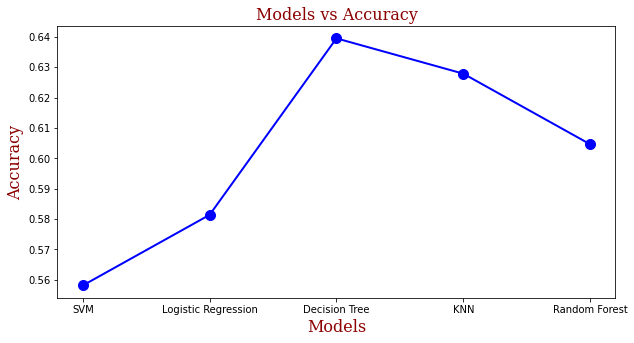

In [663]:

plt.figure(figsize=(10,5))
plt.plot(metrics_bow['model'],metrics_bow['accuracy'],'bo',linestyle='solid',linewidth=2, markersize=10)
plt.xlabel("Models",fontdict=font)
plt.ylabel("Accuracy", fontdict=font)
plt.title("Models vs Accuracy" , fontdict=font)
plt.show()


## *Word2Vec*

In [643]:
metrics_w2v

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.705,0.604651,0.753623,0.604651,1.000000
1,Logistic Regression,0.700,0.604651,0.753623,0.604651,1.000000
2,Decision Tree,0.670,0.581395,0.499997,0.496744,0.581395
3,KNN,0.710,0.604651,0.530544,0.572356,0.675325
4,Random Forest,0.725,0.604651,0.523961,0.527234,0.604651


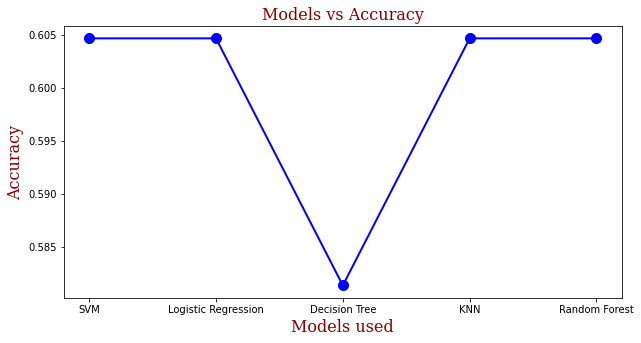

In [656]:
plt.figure(figsize=(10,5))
plt.plot(metrics_w2v['model'],metrics_w2v['accuracy'],'bo',linestyle='solid',linewidth=2, markersize=10)
plt.xlabel("Models used", fontdict=font)
plt.ylabel("Accuracy", fontdict=font)
plt.title("Models vs Accuracy", fontdict=font)
plt.show()


## *Fast Text*

In [644]:
metrics_ftxt

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.700,0.604651,0.753623,0.604651,1.000000
1,Logistic Regression,0.700,0.604651,0.753623,0.604651,1.000000
2,Decision Tree,0.675,0.581395,0.469647,0.404651,0.581395
3,KNN,0.710,0.593023,0.502796,0.405195,0.662338
4,Random Forest,0.720,0.581395,0.481863,0.483662,0.581395


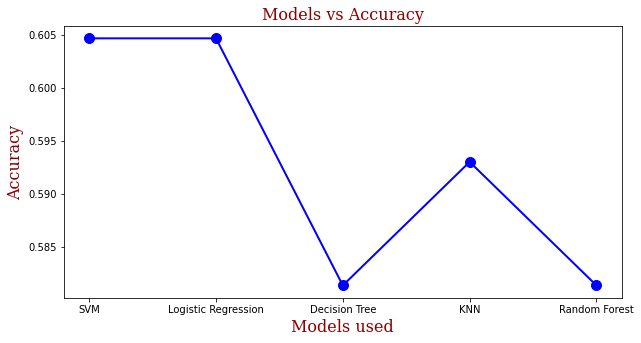

In [655]:
plt.figure(figsize=(10,5))
plt.plot(metrics_ftxt['model'],metrics_ftxt['accuracy'],'bo',linestyle='solid',linewidth=2, markersize=10)
plt.xlabel("Models used", fontdict=font)
plt.ylabel("Accuracy", fontdict=font)
plt.title("Models vs Accuracy", fontdict=font)
plt.show()
